(opt_tax_amss)=
```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# Optimal Taxation without State-Contingent Debt

In addition to what's in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install --upgrade quantecon
!pip install interpolation

## Overview

Let's start with following imports:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
from interpolation.splines import eval_linear, UCGrid, nodes
from quantecon import optimize, MarkovChain
from numba import njit, prange, float64
from numba.experimental import jitclass

In {doc}`an earlier lecture <opt_tax_recur>`, we described a model of
optimal taxation with state-contingent debt due to
Robert E. Lucas, Jr.,  and Nancy Stokey  {cite}`LucasStokey1983`.

Aiyagari, Marcet, Sargent, and Seppälä {cite}`aiyagari2002optimal`  (hereafter, AMSS)
studied optimal taxation in a model without state-contingent debt.

In this lecture, we

* describe assumptions and equilibrium concepts
* solve the model
* implement the model numerically
* conduct some policy experiments
* compare outcomes with those in a corresponding complete-markets model

We begin with an introduction to the model.

## Competitive Equilibrium with Distorting Taxes

Many but not all features of the economy are identical to those of {doc}`the Lucas-Stokey economy <opt_tax_recur>`.

Let's start with things that are identical.

For $t \geq 0$, a history of the state is represented by $s^t = [s_t, s_{t-1}, \ldots, s_0]$.

Government purchases $g(s)$ are an exact time-invariant function of $s$.

Let $c_t(s^t)$,  $\ell_t(s^t)$, and $n_t(s^t)$ denote consumption,
leisure, and labor supply, respectively, at history $s^t$ at time $t$.

Each period a representative  household is endowed with one unit of time that can be divided between  leisure
$\ell_t$ and labor $n_t$:

```{math}
:label: feas1_amss

n_t(s^t) + \ell_t(s^t) = 1
```

Output equals $n_t(s^t)$ and can be divided between consumption $c_t(s^t)$ and $g(s_t)$

```{math}
:label: TSs_techr_amss

c_t(s^t) + g(s_t) = n_t(s^t)
```

Output is not storable.

The technology pins down a pre-tax wage rate to unity for all $t, s^t$.

A representative  household’s preferences over $\{c_t(s^t), \ell_t(s^t)\}_{t=0}^\infty$ are ordered by

```{math}
:label: TS_prefr_amss

\sum_{t=0}^\infty \sum_{s^t} \beta^t \pi_t(s^t) u[c_t(s^t), \ell_t(s^t)]
```

where

* $\pi_t(s^t)$ is a joint probability distribution over the sequence $s^t$, and
* the utility function $u$ is  increasing, strictly concave, and three times  continuously differentiable in both arguments.

The government imposes a flat rate tax $\tau_t(s^t)$ on labor income at time $t$, history $s^t$.

Lucas and Stokey assumed that there are complete markets in one-period Arrow securities; also see {doc}`smoothing models <smoothing>`.

It is at this point that AMSS {cite}`aiyagari2002optimal` modify the Lucas and Stokey economy.

AMSS allow the government to issue only one-period risk-free debt each period.

Ruling out complete markets in this way is a step in the direction of making total tax collections behave more like that prescribed in Robert Barro (1979) {cite}`Barro1979` than they do in Lucas and Stokey (1983) {cite}`LucasStokey1983`.

### Risk-free One-Period Debt Only

In period $t$ and history $s^t$, let

* $b_{t+1}(s^t)$ be the amount of the time $t+1$ consumption good that at time $t$, history $s^t$ the government promised to pay
* $R_t(s^t)$ be the gross interest rate on  risk-free one-period debt between periods $t$ and $t+1$
* $T_t(s^t)$ be a non-negative lump-sum *transfer* to the representative household [^fn_a]

That $b_{t+1}(s^t)$ is the same for all realizations of $s_{t+1}$ captures its *risk-free* character.

The market value at time $t$ of government debt maturing at time $t+1$ equals $b_{t+1}(s^t)$ divided by $R_t(s^t)$.

The government’s budget constraint in period $t$ at history $s^t$ is

```{math}
:label: TS_gov_wo

\begin{aligned}
b_t(s^{t-1})
    & =    \tau^n_t(s^t) n_t(s^t) - g(s_t) - T_t(s^t) +
                   {b_{t+1}(s^t) \over R_t(s^t )}
    \\
    & \equiv z_t(s^t) + {b_{t+1}(s^t) \over R_t(s^t )},
\end{aligned}
```

where $z_t(s^t)$ is the net-of-interest government surplus.

To rule out Ponzi schemes, we assume that the government is subject to a **natural debt limit** (to be discussed in a forthcoming lecture).

The consumption Euler equation for a representative household able to trade only one-period risk-free debt
with one-period gross interest rate $R_t(s^t)$ is

$$
{1 \over R_t(s^t)}
= \sum_{s^{t+1}\vert s^t} \beta  \pi_{t+1}(s^{t+1} | s^t)
                        { u_c(s^{t+1}) \over u_c(s^{t}) }
$$

Substituting this expression into the government’s budget constraint {eq}`TS_gov_wo`
yields:

```{math}
:label: TS_gov_wo2

b_t(s^{t-1}) =  z_t(s^t) + \beta  \sum_{s^{t+1}\vert s^t}  \pi_{t+1}(s^{t+1} | s^t)
                       { u_c(s^{t+1}) \over u_c(s^{t}) } \; b_{t+1}(s^t)
```

Components of $z_t(s^t)$ on the right side depend on $s^t$, but the left side is required to depend only
on $s^{t-1}$ .

**This is what it means for one-period government debt to be risk-free**.

Therefore, the right side of equation {eq}`TS_gov_wo2` also has to depend only on $s^{t-1}$.

This requirement will give rise to **measurability constraints** on the Ramsey allocation to be discussed soon.

If we replace $b_{t+1}(s^t)$ on the right side of equation {eq}`TS_gov_wo2` by the right
side of next period’s budget constraint (associated with a
particular realization $s_{t}$) we get

$$
b_t(s^{t-1}) =  z_t(s^t) + \sum_{s^{t+1}\vert s^t} \beta  \pi_{t+1}(s^{t+1} | s^t)
                       { u_c(s^{t+1}) \over u_c(s^{t}) }
\, \left[z_{t+1}(s^{t+1}) + {b_{t+2}(s^{t+1}) \over R_{t+1}(s^{t+1})}\right]
$$

After making similar repeated substitutions for all future occurrences of
government indebtedness, and by invoking a natural debt limit, we
arrive at:

```{math}
:label: TS_gov_wo3

\begin{aligned}
b_t(s^{t-1})
    &=  \sum_{j=0}^\infty \sum_{s^{t+j} | s^t} \beta^j  \pi_{t+j}(s^{t+j} | s^t)
              { u_c(s^{t+j}) \over u_c(s^{t}) } \;z_{t+j}(s^{t+j})
        \end{aligned}
```

Notice how the conditioning sets in equation {eq}`TS_gov_wo3` differ: they are $s^{t-1}$ on the left side and
$s^t$ on the right side.

Now let's

* substitute the resource constraint into the net-of-interest government surplus, and
* use the household’s first-order condition $1-\tau^n_t(s^t)= u_{\ell}(s^t) /u_c(s^t)$ to eliminate the labor tax rate

so that we can express the net-of-interest government surplus $z_t(s^t)$ as

```{math}
:label: AMSS_44_2

z_t(s^t)
    = \left[1 - {u_{\ell}(s^t) \over u_c(s^t)}\right] \left[c_t(s^t)+g(s_t)\right]
        -g(s_t) - T_t(s^t)\,.
```

If we substitute  appropriate versions of the right side of {eq}`AMSS_44_2` for $z_{t+j}(s^{t+j})$ into equation {eq}`TS_gov_wo3`,
we obtain a sequence of *implementability constraints* on a Ramsey allocation in an AMSS economy.

Expression {eq}`TS_gov_wo3` at time $t=0$ and initial state $s^0$
was also  an *implementability constraint* on a Ramsey allocation in a Lucas-Stokey economy:

```{math}
:label: TS_gov_wo4

b_0(s^{-1}) = \mathbb E_0 \sum_{j=0}^\infty \beta^j
               { u_c(s^{j}) \over u_c(s^{0}) } \;z_j(s^{j})
```

Indeed, it was the *only* implementability constraint there.

But now we also have a large number of additional implementability constraints

```{math}
:label: TS_gov_wo4a

b_t(s^{t-1}) =  \mathbb E_t \sum_{j=0}^\infty \beta^j
              { u_c(s^{t+j}) \over u_c(s^{t}) } \;z_{t+j}(s^{t+j})
```

Equation {eq}`TS_gov_wo4a` must hold for each $s^t$ for each $t \geq 1$.

### Comparison with Lucas-Stokey Economy

The expression on the right side of {eq}`TS_gov_wo4a` in the Lucas-Stokey (1983) economy would  equal the present value of a continuation stream of government net-of-interest surpluses evaluated at what would be competitive equilibrium Arrow-Debreu prices at date $t$.

In the Lucas-Stokey economy, that present value is measurable with respect to $s^t$.

In the AMSS economy, the restriction that government debt be risk-free imposes that that same present value must be measurable with respect to $s^{t-1}$.

In a language used in the literature on incomplete markets models, it can be said that the AMSS model requires that at each $(t, s^t)$ what would be the present value of continuation government net-of-interest surpluses in the Lucas-Stokey model must belong to  the **marketable subspace** of the AMSS model.

### Ramsey Problem Without State-contingent Debt

After we have substituted the resource constraint into the utility function, we can express the Ramsey problem as being to choose an allocation that solves

$$
\max_{\{c_t(s^t),b_{t+1}(s^t)\}}
\mathbb E_0 \sum_{t=0}^\infty \beta^t
                        u\left(c_t(s^t),1-c_t(s^t)-g(s_t)\right)
$$

where the maximization is subject to

```{math}
:label: AMSS_44

\mathbb E_{0} \sum_{j=0}^\infty \beta^j
      { u_c(s^{j}) \over u_c(s^{0}) } \;z_j(s^{j}) \geq b_0(s^{-1})
```

and

```{math}
:label: AMSS_46

\mathbb E_{t} \sum_{j=0}^\infty \beta^j
    { u_c(s^{t+j}) \over u_c(s^{t}) } \;
    z_{t+j}(s^{t+j}) = b_t(s^{t-1})
      \quad \forall \, t,  s^t
```

given $b_0(s^{-1})$.

#### Lagrangian Formulation

Let $\gamma_0(s^0)$ be a non-negative Lagrange multiplier on constraint {eq}`AMSS_44`.

As in the Lucas-Stokey economy, this multiplier is strictly positive when the government must resort to
distortionary taxation; otherwise it equals zero.

A consequence of the assumption that there are no markets in state-contingent securities  and that a market exists only in a risk-free security is that we have to attach a stochastic process $\{\gamma_t(s^t)\}_{t=1}^\infty$ of
Lagrange multipliers to the implementability constraints {eq}`AMSS_46`.

Depending on how the constraints  bind, these multipliers can be positive or negative:

$$
\begin{aligned}
   \gamma_t(s^t)
   &\;\geq\; (\leq)\;\, 0 \quad \text{if the constraint binds in the following direction }
   \\
   & \mathbb E_{t} \sum_{j=0}^\infty \beta^j
    { u_c(s^{t+j}) \over u_c(s^{t}) } \;z_{t+j}(s^{t+j}) \;\geq \;(\leq)\;\, b_t(s^{t-1})
\end{aligned}
$$

A negative multiplier $\gamma_t(s^t)<0$ means that if we could
relax constraint {eq}`AMSS_46`, we would like to *increase* the beginning-of-period
indebtedness for that particular realization of history $s^t$.

That would let us reduce the beginning-of-period indebtedness for some other history [^fn_b].

These features flow from  the fact that the government cannot use state-contingent debt and therefore cannot allocate its indebtedness  efficiently across future states.

### Some Calculations

It is helpful to apply two transformations to the Lagrangian.

Multiply constraint {eq}`AMSS_44` by $u_c(s^0)$ and the constraints {eq}`AMSS_46` by $\beta^t u_c(s^{t})$.

Then a Lagrangian for the Ramsey problem can  be represented as

```{math}
:label: AMSS_lagr;a

\begin{aligned}
   J &= \mathbb E_{0} \sum_{t=0}^\infty \beta^t
                        \biggl\{ u\left(c_t(s^t), 1-c_t(s^t)-g(s_t)\right)\\
   &  \qquad + \gamma_t(s^t) \Bigl[ \mathbb E_{t} \sum_{j=0}^\infty \beta^j
         u_c(s^{t+j}) \,z_{t+j}(s^{t+j}) - u_c(s^{t}) \,b_t(s^{t-1}) \biggr\}
         \\
   &= \mathbb E_{0} \sum_{t=0}^\infty \beta^t
                         \biggl\{ u\left(c_t(s^t), 1-c_t(s^t)-g(s_t)\right)
        \\
   &  \qquad + \Psi_t(s^t)\, u_c(s^{t}) \,z_t(s^{t}) -
                   \gamma_t(s^t)\, u_c(s^{t}) \, b_t(s^{t-1})  \biggr\}
\end{aligned}
```

where

```{math}
:label: AMSS_lagr;

\Psi_t(s^t)=\Psi_{t-1}(s^{t-1})+\gamma_t(s^t)
 \quad \text{and} \quad
\Psi_{-1}(s^{-1})=0
```

In {eq}`AMSS_lagr;a`,  the second equality uses  the law of iterated expectations
and Abel’s summation formula (also called *summation by parts*, see
[this page](https://en.wikipedia.org/wiki/Abel%27s_summation_formula)).

First-order conditions with respect
to $c_t(s^t)$ can be expressed as

```{math}
:label: AMSS_foc;a

\begin{aligned}
  u_c(s^t)-u_{\ell}(s^t) &+ \Psi_t(s^t)\left\{ \left[
    u_{cc}(s^t) - u_{c\ell}(s^{t})\right]z_t(s^{t}) +
    u_{c}(s^{t})\,z_c(s^{t}) \right\}
    \\
    & \hspace{35mm} - \gamma_t(s^t)\left[
    u_{cc}(s^{t}) - u_{c\ell}(s^{t})\right]b_t(s^{t-1}) =0
\end{aligned}
```

and with respect to $b_t(s^t)$ as

```{math}
:label: AMSS_foc;b

\mathbb E_{t} \left[\gamma_{t+1}(s^{t+1})\,u_c(s^{t+1})\right] = 0
```

If we substitute $z_t(s^t)$ from {eq}`AMSS_44_2` and its derivative
$z_c(s^t)$ into the first-order condition {eq}`AMSS_foc;a`, we  find  two
differences from the corresponding condition for the optimal allocation
in a Lucas-Stokey economy with state-contingent government debt.

1. The term involving $b_t(s^{t-1})$ in the first-order condition
   {eq}`AMSS_foc;a` does not appear in the corresponding expression
   for the Lucas-Stokey economy.
    * This term reflects the constraint that
      beginning-of-period government indebtedness must be the same across all
      realizations of next period’s state, a constraint that would  not be present if
      government debt could be state-contingent.
1. The Lagrange multiplier $\Psi_t(s^t)$ in the first-order condition
   {eq}`AMSS_foc;a` may change over time in response to realizations of the state,
   while the multiplier $\Phi$ in the Lucas-Stokey economy is time-invariant.

We need some code from  {doc}`an earlier lecture <opt_tax_recur>`
on optimal taxation with state-contingent debt  sequential allocation implementation:

In [3]:
class SequentialLS:

    '''
    Class that takes a preference object, state transition matrix,
    and state contingent government expenditure plan as inputs, and
    solves the sequential allocation problem described above.
    It returns optimal allocations about consumption and labor supply,
    as well as the multiplier on the implementability constraint Φ.
    '''

    def __init__(self,
                 pref,
                 π=np.full((2, 2), 0.5),
                 g=np.array([0.1, 0.2])):

        # Initialize from pref object attributes
        self.β, self.π, self.g = pref.β, π, g
        self.mc = MarkovChain(self.π)
        self.S = len(π)  # Number of states
        self.pref = pref

        # Find the first best allocation
        self.find_first_best()

    def FOC_first_best(self, c, g):
        '''
        First order conditions that characterize
        the first best allocation.
        '''

        pref = self.pref
        Uc, Ul = pref.Uc, pref.Ul

        n = c + g
        l = 1 - n

        return Uc(c, l) - Ul(c, l)

    def find_first_best(self):
        '''
        Find the first best allocation
        '''
        S, g = self.S, self.g

        res = root(self.FOC_first_best, np.full(S, 0.5), args=(g,))

        if (res.fun > 1e-10).any():
            raise Exception('Could not find first best')

        self.cFB = res.x
        self.nFB = self.cFB + g

    def FOC_time1(self, c, Φ, g):
        '''
        First order conditions that characterize
        optimal time 1 allocation problems.
        '''

        pref = self.pref
        Uc, Ucc, Ul, Ull, Ulc = pref.Uc, pref.Ucc, pref.Ul, pref.Ull, pref.Ulc

        n = c + g
        l = 1 - n

        LHS = (1 + Φ) * Uc(c, l) + Φ * (c * Ucc(c, l) - n * Ulc(c, l))
        RHS = (1 + Φ) * Ul(c, l) + Φ * (c * Ulc(c, l) - n * Ull(c, l))

        diff = LHS - RHS

        return diff

    def time1_allocation(self, Φ):
        '''
        Computes optimal allocation for time t >= 1 for a given Φ
        '''
        pref = self.pref
        S, g = self.S, self.g

        # use the first best allocation as intial guess
        res = root(self.FOC_time1, self.cFB, args=(Φ, g))

        if (res.fun > 1e-10).any():
            raise Exception('Could not find LS allocation.')

        c = res.x
        n = c + g
        l = 1 - n

        # Compute x
        I = pref.Uc(c, n) * c - pref.Ul(c, l) * n
        x = np.linalg.solve(np.eye(S) - self.β * self.π, I)

        return c, n, x

    def FOC_time0(self, c0, Φ, g0, b0):
        '''
        First order conditions that characterize
        time 0 allocation problem.
        '''

        pref = self.pref
        Ucc, Ulc = pref.Ucc, pref.Ulc

        n0 = c0 + g0
        l0 = 1 - n0

        diff = self.FOC_time1(c0, Φ, g0)
        diff -= Φ * (Ucc(c0, l0) - Ulc(c0, l0)) * b0

        return diff

    def implementability(self, Φ, b0, s0, cn0_arr):
        '''
        Compute the differences between the RHS and LHS
        of the implementability constraint given Φ,
        initial debt, and initial state.
        '''

        pref, π, g, β = self.pref, self.π, self.g, self.β
        Uc, Ul = pref.Uc, pref.Ul
        g0 = self.g[s0]

        c, n, x = self.time1_allocation(Φ)

        res = root(self.FOC_time0, cn0_arr[0], args=(Φ, g0, b0))
        c0 = res.x
        n0 = c0 + g0
        l0 = 1 - n0

        cn0_arr[:] = c0.item(), n0.item()

        LHS = Uc(c0, l0) * b0
        RHS = Uc(c0, l0) * c0 - Ul(c0, l0) * n0 + β * π[s0] @ x

        return RHS - LHS

    def time0_allocation(self, b0, s0):
        '''
        Finds the optimal time 0 allocation given
        initial government debt b0 and state s0
        '''

        # use the first best allocation as initial guess
        cn0_arr = np.array([self.cFB[s0], self.nFB[s0]])

        res = root(self.implementability, 0., args=(b0, s0, cn0_arr))

        if (res.fun > 1e-10).any():
            raise Exception('Could not find time 0 LS allocation.')

        Φ = res.x[0]
        c0, n0 = cn0_arr

        return Φ, c0, n0

    def τ(self, c, n):
        '''
        Computes τ given c, n
        '''
        pref = self.pref
        Uc, Ul = pref.Uc, pref.Ul

        return 1 - Ul(c, 1-n) / Uc(c, 1-n)

    def simulate(self, b0, s0, T, sHist=None):
        '''
        Simulates planners policies for T periods
        '''
        pref, π, β = self.pref, self.π, self.β
        Uc = pref.Uc

        if sHist is None:
            sHist = self.mc.simulate(T, s0)

        cHist, nHist, Bhist, τHist, ΦHist = np.empty((5, T))
        RHist = np.empty(T-1)

        # Time 0
        Φ, cHist[0], nHist[0] = self.time0_allocation(b0, s0)
        τHist[0] = self.τ(cHist[0], nHist[0])
        Bhist[0] = b0
        ΦHist[0] = Φ

        # Time 1 onward
        for t in range(1, T):
            c, n, x = self.time1_allocation(Φ)
            τ = self.τ(c, n)
            u_c = Uc(c, 1-n)
            s = sHist[t]
            Eu_c = π[sHist[t-1]] @ u_c
            cHist[t], nHist[t], Bhist[t], τHist[t] = c[s], n[s], x[s] / u_c[s], τ[s]
            RHist[t-1] = Uc(cHist[t-1], 1-nHist[t-1]) / (β * Eu_c)
            ΦHist[t] = Φ

        gHist = self.g[sHist]
        yHist = nHist

        return [cHist, nHist, Bhist, τHist, gHist, yHist, sHist, ΦHist, RHist]


To analyze the AMSS model, we find it useful to adopt a recursive formulation
using techniques like those in our lectures on {doc}`dynamic Stackelberg models <dyn_stack>` and {doc}`optimal taxation with state-contingent debt <opt_tax_recur>`.

## Recursive Version of AMSS Model

We now describe a recursive formulation of the AMSS economy.

We have noted that from the point of view of the Ramsey planner, the restriction
to one-period risk-free securities

* leaves intact the single implementability constraint on allocations
  {eq}`TS_gov_wo4` from the Lucas-Stokey economy, but
* adds measurability constraints {eq}`TS_gov_wo3` on functions of tails of
  allocations at each time and history

We now explore how these constraints alter  Bellman equations for a time
$0$ Ramsey planner and for time $t \geq 1$, history $s^t$
continuation Ramsey planners.

### Recasting State Variables

In the AMSS setting, the government faces a sequence of budget constraints

$$
\tau_t(s^t) n_t(s^t) + T_t(s^t) +  b_{t+1}(s^t)/ R_t (s^t) =  g_t + b_t(s^{t-1})
$$

where $R_t(s^t)$ is the gross risk-free rate of interest between $t$
and $t+1$ at history $s^t$ and $T_t(s^t)$ are non-negative transfers.

Throughout this lecture, we shall set transfers to zero (for some issues about the limiting behavior of debt, this is  possibly an important  difference from AMSS {cite}`aiyagari2002optimal`, who restricted transfers
to be non-negative).

In this case, the household faces a sequence of budget constraints

```{math}
:label: eqn:AMSSapp1

b_t(s^{t-1}) + (1-\tau_t(s^t)) n_t(s^t) = c_t(s^t) + b_{t+1}(s^t)/R_t(s^t)
```

The household’s first-order conditions are $u_{c,t} = \beta R_t \mathbb E_t u_{c,t+1}$
and $(1-\tau_t) u_{c,t} = u_{l,t}$.

Using these to eliminate $R_t$ and $\tau_t$ from  budget constraint
{eq}`eqn:AMSSapp1` gives

```{math}
:label: eqn:AMSSapp2a

b_t(s^{t-1}) + \frac{u_{l,t}(s^t)}{u_{c,t}(s^t)} n_t(s^t)
= c_t(s^t) + {\frac{\beta (\mathbb E_t u_{c,t+1}) b_{t+1}(s^t)}{u_{c,t}(s^t)}}
```

or

```{math}
:label: eqn:AMSSapp2

u_{c,t}(s^t) b_t(s^{t-1}) + u_{l,t}(s^t) n_t(s^t)
= u_{c,t}(s^t) c_t(s^t) + \beta (\mathbb E_t u_{c,t+1}) b_{t+1}(s^t)
```

Now define

```{math}
:label: eqn:AMSSapp3

x_t \equiv \beta b_{t+1}(s^t) \mathbb E_t u_{c,t+1} = u_{c,t} (s^t) {\frac{b_{t+1}(s^t)}{R_t(s^t)}}
```

and represent the household’s budget constraint at time $t$,
history $s^t$ as

```{math}
:label: eqn:AMSSapp4

{\frac{u_{c,t} x_{t-1}}{\beta \mathbb E_{t-1} u_{c,t}}} = u_{c,t} c_t - u_{l,t} n_t + x_t
```

for $t \geq 1$.

### Measurability Constraints

Write equation {eq}`eqn:AMSSapp2` as

```{math}
:label: eqn:AMSSapp2b

b_t(s^{t-1})  = c_t(s^t) -  { \frac{u_{l,t}(s^t)}{u_{c,t}(s^t)}} n_t(s^t) +
{\frac{\beta (\mathbb E_t u_{c,t+1}) b_{t+1}(s^t)}{u_{c,t}}}
```

The right side of equation {eq}`eqn:AMSSapp2b` expresses the time $t$ value of government debt
in terms of a linear combination of terms whose individual components
are measurable with respect to $s^t$.

The sum  of terms on the right side  of equation {eq}`eqn:AMSSapp2b` must equal
$b_t(s^{t-1})$.

That implies that it has to be *measurable* with respect to $s^{t-1}$.

Equations {eq}`eqn:AMSSapp2b` are the *measurability constraints* that the AMSS model adds to the single time $0$ implementation
constraint imposed in the Lucas and Stokey model.

### Two Bellman Equations

Let $\Pi(s|s_-)$ be a Markov transition matrix whose entries tell probabilities of moving from state $s_-$ to state $s$ in one period.

Let

* $V(x_-, s_-)$ be the continuation value of a continuation
  Ramsey plan at $x_{t-1} = x_-, s_{t-1} =s_-$ for $t \geq 1$
* $W(b, s)$ be the value of the Ramsey plan at time $0$ at
  $b_0=b$ and $s_0 = s$

We distinguish between two types of planners:

For $t \geq 1$, the value function for a **continuation Ramsey planner**
satisfies the Bellman equation

```{math}
:label: eqn:AMSSapp5

V(x_-,s_-) = \max_{\{n(s), x(s)\}} \sum_s \Pi(s|s_-) \left[ u(n(s) -
g(s), 1-n(s)) + \beta V(x(s),s) \right]
```

subject to the following collection of implementability constraints, one
for each $s \in {\cal S}$:

```{math}
:label: eqn:AMSSapp6

{\frac{u_c(s) x_- }{\beta \sum_{\tilde s} \Pi(\tilde s|s_-) u_c(\tilde s) }}
= u_c(s) (n(s) - g(s)) - u_l(s) n(s) + x(s)
```

A continuation Ramsey planner at $t \geq 1$ takes
$(x_{t-1}, s_{t-1}) = (x_-, s_-)$ as given and before
$s$ is realized chooses
$(n_t(s_t), x_t(s_t)) = (n(s), x(s))$ for $s \in  {\cal S}$.

The **Ramsey planner** takes $(b_0, s_0)$ as given and chooses $(n_0, x_0)$.

The value function $W(b_0, s_0)$   for the time $t=0$ Ramsey planner
satisfies the Bellman equation

```{math}
:label: eqn:AMSSapp100

W(b_0, s_0) = \max_{n_0, x_0} u(n_0 - g_0, 1-n_0) + \beta V(x_0,s_0)
```

where maximization is subject to

```{math}
:label: eqn:AMMSSapp101

u_{c,0} b_0 = u_{c,0} (n_0-g_0) - u_{l,0} n_0 + x_0
```

### Martingale Supercedes State-Variable Degeneracy

Let $\mu(s|s_-) \Pi(s|s_-)$ be a Lagrange multiplier on the constraint {eq}`eqn:AMSSapp6`
for state $s$.

After forming an appropriate Lagrangian, we find that the continuation Ramsey planner’s first-order
condition with respect to $x(s)$ is

```{math}
:label: eqn:AMSSapp7

\beta V_x(x(s),s) = \mu(s|s_-)
```

Applying an envelope theorem to Bellman equation {eq}`eqn:AMSSapp5` gives

```{math}
:label: eqn:AMSSapp8

V_x(x_-,s_-) = \sum_s \Pi(s|s_-) \mu(s|s_-) {\frac{u_c(s)}{\beta \sum_{\tilde s}
\Pi(\tilde s|s_-) u_c(\tilde s) }}
```

Equations {eq}`eqn:AMSSapp7` and {eq}`eqn:AMSSapp8` imply that

```{math}
:label: eqn:AMSSapp9

V_x(x_-, s_-) = \sum_{s} \left( \Pi(s|s_-) {\frac{u_c(s)}{\sum_{\tilde s}
\Pi(\tilde s| s_-) u_c(\tilde s)}} \right) V_x(x, s)
```

Equation {eq}`eqn:AMSSapp9` states that $V_x(x, s)$ is a *risk-adjusted martingale*.

Saying that $V_x(x, s)$ is a risk-adjusted martingale  means  that
$V_x(x, s)$  is a martingale with respect to the probability distribution
over $s^t$ sequences that are generated by the *twisted* transition probability matrix:

$$
\check \Pi(s|s_-) \equiv \Pi(s|s_-) {\frac{u_c(s)}{\sum_{\tilde s}
\Pi(\tilde s| s_-) u_c(\tilde s)}}
$$

```{exercise-start}
:label: amss_ex1
```
Please verify that $\check \Pi(s|s_-)$ is a valid Markov
transition density, i.e., that its elements are all non-negative and
that for each $s_-$, the sum over $s$ equals unity.

```{exercise-end}
```

### Absence of State Variable Degeneracy

Along a Ramsey plan, the state variable $x_t = x_t(s^t, b_0)$
becomes a function of the history $s^t$ and initial
government debt $b_0$.

In {doc}`Lucas-Stokey model <opt_tax_recur>`, we
found that

* a counterpart to $V_x(x,s)$ is time-invariant and equal to
  the Lagrange multiplier on the Lucas-Stokey implementability constraint
* time invariance of $V_x(x,s)$  is the source of a key
  feature of the Lucas-Stokey model, namely, **state variable degeneracy** in which $x_t$ is an exact time-invariant function of $s_t$.

That $V_x(x,s)$ varies over time according to a twisted martingale
means that there is no state-variable degeneracy in the AMSS model.

In the AMSS model, both $x$ and $s$ are needed to describe the state.

This property of the AMSS model  transmits a twisted martingale
component to consumption, employment, and the tax rate.

### Digression on Non-negative Transfers

Throughout this lecture, we have imposed that transfers $T_t = 0$.

AMSS {cite}`aiyagari2002optimal` instead imposed a nonnegativity
constraint $T_t\geq 0$ on transfers.

They also considered a special case of quasi-linear preferences,
$u(c,l)= c + H(l)$.

In this case, $V_x(x,s)\leq 0$ is a non-positive martingale.

By the *martingale convergence theorem*  $V_x(x,s)$ converges almost surely.

Furthermore, when the Markov chain $\Pi(s| s_-)$ and the government
expenditure function $g(s)$ are such that $g_t$ is perpetually
random, $V_x(x, s)$ almost surely converges to zero.

For quasi-linear preferences, the first-order condition for maximizing {eq}`eqn:AMSSapp5` subject to  {eq}`eqn:AMSSapp6` with respect to $n(s)$ becomes

$$
(1-\mu(s|s_-) ) (1 - u_l(s)) + \mu(s|s_-) n(s) u_{ll}(s) =0
$$

When $\mu(s|s_-) = \beta V_x(x(s),x)$ converges to zero, in the limit
$u_l(s)= 1 =u_c(s)$, so that $\tau(x(s),s) =0$.

Thus, in the limit, if $g_t$ is perpetually random,  the government
accumulates sufficient assets to finance all expenditures from earnings on those
assets, returning any excess revenues to the household as non-negative lump-sum transfers.

### Code

The recursive formulation is implemented as follows

In [4]:
class AMSS:
    # WARNING: THE CODE IS EXTREMELY SENSITIVE TO CHOCIES OF PARAMETERS.
    # DO NOT CHANGE THE PARAMETERS AND EXPECT IT TO WORK

    def __init__(self, pref, β, Π, g, x_grid, bounds_v):
        self.β, self.Π, self.g = β, Π, g
        self.x_grid = x_grid
        self.n = x_grid[0][2]
        self.S = len(Π)
        self.bounds = bounds_v
        self.pref = pref

        self.T_v, self.T_w = bellman_operator_factory(Π, β, x_grid, g,
                                                      bounds_v)

        self.V_solved = False
        self.W_solved = False

    def compute_V(self, V, σ_v_star, tol_vfi, maxitr, print_itr):

        T_v = self.T_v

        self.success = False

        V_new = np.zeros_like(V)

        Δ = 1.0
        for itr in range(maxitr):
            T_v(V, V_new, σ_v_star, self.pref)

            Δ = np.max(np.abs(V_new - V))

            if Δ < tol_vfi:
                self.V_solved = True
                print('Successfully completed VFI after %i iterations'
                      % (itr+1))
                break

            if (itr + 1) % print_itr == 0:
                print('Error at iteration %i : ' % (itr + 1), Δ)

            V[:] = V_new[:]

        self.V = V
        self.σ_v_star = σ_v_star

        return V, σ_v_star

    def compute_W(self, b_0, W, σ_w_star):
        T_w = self.T_w
        V = self.V

        T_w(W, σ_w_star, V, b_0, self.pref)

        self.W = W
        self.σ_w_star = σ_w_star
        self.W_solved = True
        print('Succesfully solved the time 0 problem.')

        return W, σ_w_star

    def solve(self, V, σ_v_star,  b_0, W, σ_w_star, tol_vfi=1e-7,
              maxitr=1000, print_itr=10):
        print("===============")
        print("Solve time 1 problem")
        print("===============")
        self.compute_V(V, σ_v_star, tol_vfi, maxitr, print_itr)
        print("===============")
        print("Solve time 0 problem")
        print("===============")
        self.compute_W(b_0, W, σ_w_star)

    def simulate(self, s_hist, b_0):
        if not (self.V_solved and self.W_solved):
            msg = "V and W need to be successfully computed before simulation."
            raise ValueError(msg)

        pref = self.pref
        x_grid, g, β, S = self.x_grid, self.g, self.β, self.S
        σ_v_star, σ_w_star = self.σ_v_star, self.σ_w_star

        T = len(s_hist)
        s_0 = s_hist[0]

        # Pre-allocate
        n_hist = np.zeros(T)
        x_hist = np.zeros(T)
        c_hist = np.zeros(T)
        τ_hist = np.zeros(T)
        b_hist = np.zeros(T)
        g_hist = np.zeros(T)

        # Compute t = 0
        l_0, T_0 = σ_w_star[s_0]
        c_0 = (1 - l_0) - g[s_0]
        x_0 = (-pref.Uc(c_0, l_0) * (c_0 - T_0 - b_0) +
               pref.Ul(c_0, l_0) * (1 - l_0))

        n_hist[0] = (1 - l_0)
        x_hist[0] = x_0
        c_hist[0] = c_0
        τ_hist[0] = 1 - pref.Ul(c_0, l_0) / pref.Uc(c_0, l_0)
        b_hist[0] = b_0
        g_hist[0] = g[s_0]

        # Compute t > 0
        for t in range(T - 1):
            x_ = x_hist[t]
            s_ = s_hist[t]
            l = np.zeros(S)
            T = np.zeros(S)
            for s in range(S):
                x_arr = np.array([x_])
                l[s] = eval_linear(x_grid, σ_v_star[s_, :, s], x_arr)
                T[s] = eval_linear(x_grid, σ_v_star[s_, :, S+s], x_arr)

            c = (1 - l) - g
            u_c = pref.Uc(c, l)
            Eu_c = Π[s_] @ u_c

            x = u_c * x_ / (β * Eu_c) - u_c * (c - T) + pref.Ul(c, l) * (1 - l)

            c_next = c[s_hist[t+1]]
            l_next = l[s_hist[t+1]]

            x_hist[t+1] = x[s_hist[t+1]]
            n_hist[t+1] = 1 - l_next
            c_hist[t+1] = c_next
            τ_hist[t+1] = 1 - pref.Ul(c_next, l_next) / pref.Uc(c_next, l_next)
            b_hist[t+1] = x_ / (β * Eu_c)
            g_hist[t+1] = g[s_hist[t+1]]

        return c_hist, n_hist, b_hist, τ_hist, g_hist, n_hist


def obj_factory(Π, β, x_grid, g):
    S = len(Π)

    @njit
    def obj_V(σ, state, V, pref):
        # Unpack state
        s_, x_ = state

        l = σ[:S]
        T = σ[S:]

        c = (1 - l) - g
        u_c = pref.Uc(c, l)
        Eu_c = Π[s_] @ u_c
        x = u_c * x_ / (β * Eu_c) - u_c * (c - T) + pref.Ul(c, l) * (1 - l)

        V_next = np.zeros(S)

        for s in range(S):
            V_next[s] = eval_linear(x_grid, V[s], np.array([x[s]]))

        out = Π[s_] @ (pref.U(c, l) + β * V_next)

        return out

    @njit
    def obj_W(σ, state, V, pref):
        # Unpack state
        s_, b_0 = state
        l, T = σ

        c = (1 - l) - g[s_]
        x = -pref.Uc(c, l) * (c - T - b_0) + pref.Ul(c, l) * (1 - l)

        V_next = eval_linear(x_grid, V[s_], np.array([x]))

        out = pref.U(c, l) + β * V_next

        return out

    return obj_V, obj_W


def bellman_operator_factory(Π, β, x_grid, g, bounds_v):
    obj_V, obj_W = obj_factory(Π, β, x_grid, g)
    n = x_grid[0][2]
    S = len(Π)
    x_nodes = nodes(x_grid)

    @njit(parallel=True)
    def T_v(V, V_new, σ_star, pref):
        for s_ in prange(S):
            for x_i in prange(n):
                state = (s_, x_nodes[x_i])
                x0 = σ_star[s_, x_i]
                res = optimize.nelder_mead(obj_V, x0, bounds=bounds_v,
                                           args=(state, V, pref))

                if res.success:
                    V_new[s_, x_i] = res.fun
                    σ_star[s_, x_i] = res.x
                else:
                    print("Optimization routine failed.")

    bounds_w = np.array([[-9.0, 1.0], [0., 10.]])

    def T_w(W, σ_star, V, b_0, pref):
        for s_ in prange(S):
            state = (s_, b_0)
            x0 = σ_star[s_]
            res = optimize.nelder_mead(obj_W, x0, bounds=bounds_w,
                                       args=(state, V, pref))

            W[s_] = res.fun
            σ_star[s_] = res.x

    return T_v, T_w


## Examples

We now turn to some examples.

### Anticipated One-Period War

In our lecture on {doc}`optimal taxation with state-contingent debt <opt_tax_recur>`
we studied how the government manages uncertainty in a simple setting.

As in that lecture, we assume the one-period utility function

$$
u(c,n) = {\frac{c^{1-\sigma}}{1-\sigma}} - {\frac{n^{1+\gamma}}{1+\gamma}}
$$

```{note}
For convenience in  matching our computer code, we have expressed
utility as a function of $n$ rather than leisure $l$.
```

We first consider a government expenditure process that we  studied earlier in a lecture on
{doc}`optimal taxation with state-contingent debt <opt_tax_recur>`.

Government expenditures are known for sure in all periods except one.

* For $t<3$ or $t > 3$ we assume that $g_t = g_l = 0.1$.
* At $t = 3$ a war occurs with probability 0.5.
    * If there is war, $g_3 = g_h = 0.2$.
    * If there is no war $g_3 = g_l = 0.1$.

A useful trick is to define  components of the state vector as the following six
$(t,g)$ pairs:

$$
(0,g_l), (1,g_l), (2,g_l), (3,g_l), (3,g_h), (t\geq 4,g_l)
$$

We think of these 6 states as corresponding to $s=1,2,3,4,5,6$.

The transition matrix is

$$
P = \begin{pmatrix}
  0 & 1 & 0 & 0   & 0   & 0\\
  0 & 0 & 1 & 0   & 0   & 0\\
  0 & 0 & 0 & 0.5 & 0.5 & 0\\
  0 & 0 & 0 & 0   & 0   & 1\\
  0 & 0 & 0 & 0   & 0   & 1\\
  0 & 0 & 0 & 0   & 0   & 1
\end{pmatrix}
$$

The government expenditure at  each state is

$$
g = \left(\begin{matrix} 0.1\\0.1\\0.1\\0.1\\0.2\\0.1 \end{matrix}\right)
$$

We assume the same utility parameters as in the {doc}`Lucas-Stokey economy <opt_tax_recur>`.

This utility function is implemented in the following class.

In [5]:
crra_util_data = [
    ('β', float64),
    ('σ', float64),
    ('γ', float64)
]

@jitclass(crra_util_data)
class CRRAutility:

    def __init__(self,
                 β=0.9,
                 σ=2,
                 γ=2):

        self.β, self.σ, self.γ = β, σ, γ

    # Utility function
    def U(self, c, l):
        # Note: `l` should not be interpreted as labor, it is an auxiliary
        # variable used to conveniently match the code and the equations
        # in the lecture
        σ = self.σ
        if σ == 1.:
            U = np.log(c)
        else:
            U = (c**(1 - σ) - 1) / (1 - σ)
        return U - (1-l) ** (1 + self.γ) / (1 + self.γ)

    # Derivatives of utility function
    def Uc(self, c, l):
        return c ** (-self.σ)

    def Ucc(self, c, l):
        return -self.σ * c ** (-self.σ - 1)

    def Ul(self, c, l):
        return (1-l) ** self.γ

    def Ull(self, c, l):
        return -self.γ * (1-l) ** (self.γ - 1)

    def Ucl(self, c, l):
        return 0

    def Ulc(self, c, l):
        return 0


The following figure plots  Ramsey plans under complete and incomplete
markets for both possible realizations of the state at time $t=3$.

Ramsey outcomes and  policies when  the government has  access to state-contingent debt are
represented by black lines and  by red lines when there is only a risk-free bond.

Paths with circles are histories in which there is peace, while those with
triangle denote war.

In [6]:
# WARNING: DO NOT EXPECT THE CODE TO WORK IF YOU CHANGE PARAMETERS
σ = 2
γ = 2
β = 0.9
Π = np.array([[0, 1, 0,   0,   0,  0],
              [0, 0, 1,   0,   0,  0],
              [0, 0, 0, 0.5, 0.5,  0],
              [0, 0, 0,   0,   0,  1],
              [0, 0, 0,   0,   0,  1],
              [0, 0, 0,   0,   0,  1]])
g = np.array([0.1, 0.1, 0.1, 0.2, 0.1, 0.1])

x_min = -1.5555
x_max = 17.339
x_num = 300

x_grid = UCGrid((x_min, x_max, x_num))

crra_pref = CRRAutility(β=β, σ=σ, γ=γ)

S = len(Π)
bounds_v = np.vstack([np.hstack([np.full(S, -10.), np.zeros(S)]),
                      np.hstack([np.ones(S) - g, np.full(S, 10.)])]).T

amss_model = AMSS(crra_pref, β, Π, g, x_grid, bounds_v)

In [7]:
# WARNING: DO NOT EXPECT THE CODE TO WORK IF YOU CHANGE PARAMETERS
V = np.zeros((len(Π), x_num))
V[:] = -nodes(x_grid).T ** 2

σ_v_star = np.ones((S, x_num, S * 2))
σ_v_star[:, :, :S] = 0.0

W = np.empty(len(Π))
b_0 = 1.0
σ_w_star = np.ones((S, 2))
σ_w_star[:, 0] = -0.05

In [8]:
%%time

amss_model.solve(V, σ_v_star, b_0, W, σ_w_star)

Solve time 1 problem


Error at iteration 10 :  1.110064840137854


Error at iteration 20 :  0.30784885876438395


Error at iteration 30 :  0.03221851531398379


Error at iteration 40 :  0.014347598008733087


Error at iteration 50 :  0.0031219444631354065


Error at iteration 60 :  0.0010783647355108172


Error at iteration 70 :  0.0003761255356202753


Error at iteration 80 :  0.0001318127597098595


Error at iteration 90 :  4.650031579878089e-05


Error at iteration 100 :  1.801377708510188e-05


Error at iteration 110 :  6.175872600877597e-06


Error at iteration 120 :  2.4450291853383987e-06


Error at iteration 130 :  1.0836745989450947e-06


Error at iteration 140 :  5.682877084467464e-07


Error at iteration 150 :  3.567560966644123e-07


Error at iteration 160 :  2.5837734796141376e-07


Error at iteration 170 :  2.047536575844333e-07


Error at iteration 180 :  1.7066849622437985e-07


Error at iteration 190 :  1.4622035848788073e-07


Error at iteration 200 :  1.27387780324284e-07


Error at iteration 210 :  1.1226231499961159e-07


Successfully completed VFI after 220 iterations
Solve time 0 problem


Succesfully solved the time 0 problem.
CPU times: user 1min 10s, sys: 1.64 s, total: 1min 12s
Wall time: 37.8 s


In [9]:
# Solve the LS model
ls_model = SequentialLS(crra_pref, g=g, π=Π)

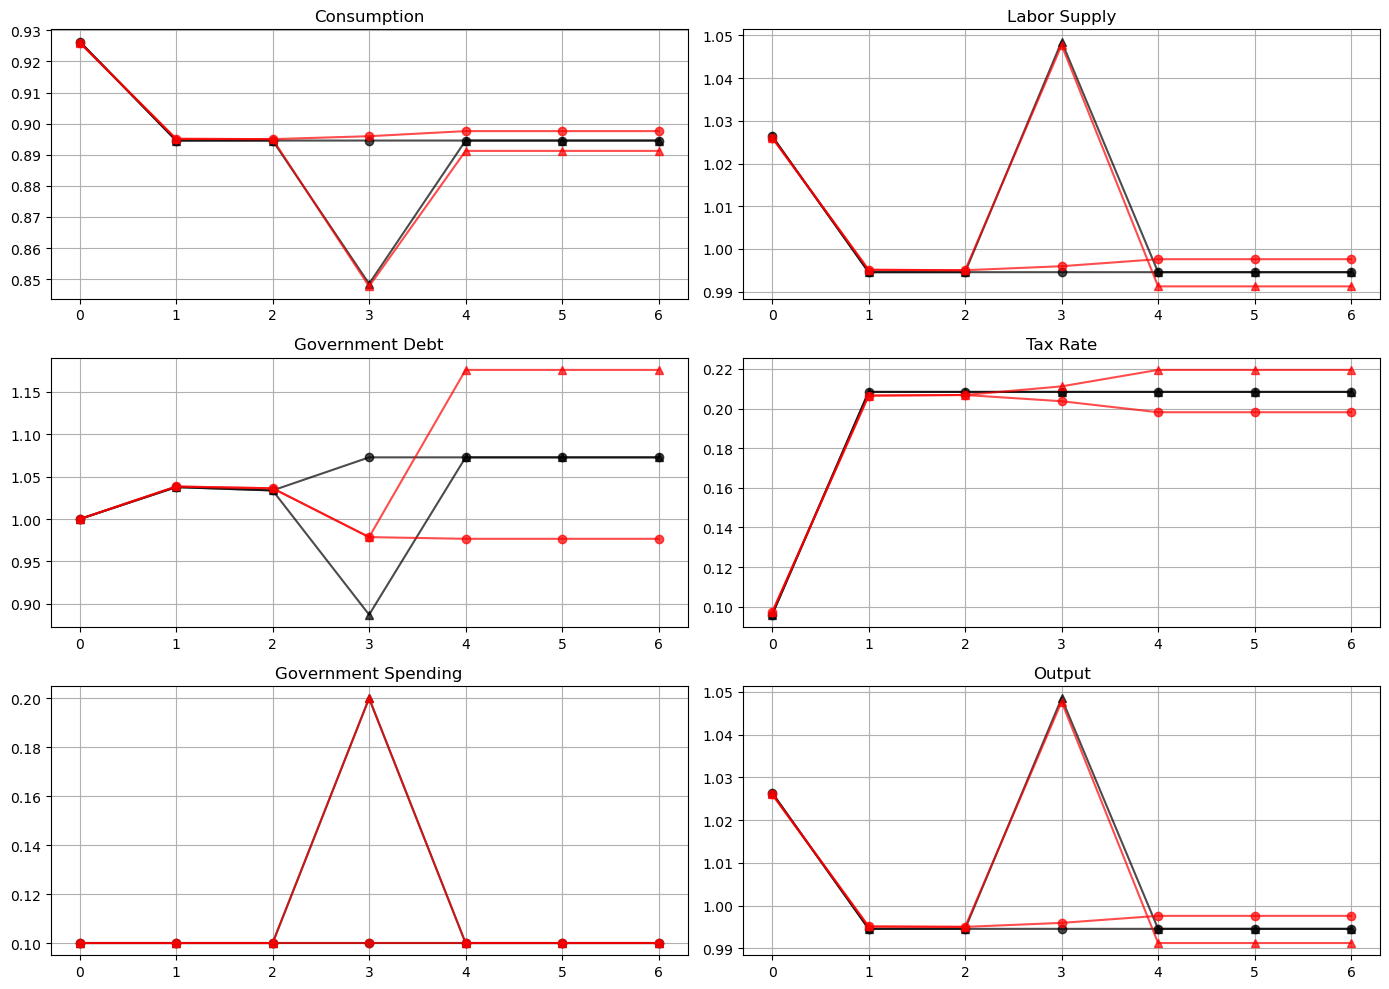

In [10]:
# WARNING: DO NOT EXPECT THE CODE TO WORK IF YOU CHANGE PARAMETERS
s_hist_h = np.array([0, 1, 2, 3, 5, 5, 5])
s_hist_l = np.array([0, 1, 2, 4, 5, 5, 5])

sim_h_amss = amss_model.simulate(s_hist_h, b_0)
sim_l_amss = amss_model.simulate(s_hist_l, b_0)

sim_h_ls = ls_model.simulate(b_0, 0, 7, s_hist_h)
sim_l_ls = ls_model.simulate(b_0, 0, 7, s_hist_l)

fig, axes = plt.subplots(3, 2, figsize=(14, 10))
titles = ['Consumption', 'Labor Supply', 'Government Debt',
          'Tax Rate', 'Government Spending', 'Output']

for ax, title, ls_l, ls_h, amss_l, amss_h in zip(axes.flatten(), titles,
                                                 sim_l_ls, sim_h_ls,
                                                 sim_l_amss, sim_h_amss):
    ax.plot(ls_l, '-ok', ls_h, '-^k', amss_l, '-or', amss_h, '-^r',
            alpha=0.7)
    ax.set(title=title)
    ax.grid()

plt.tight_layout()
plt.show()

How a Ramsey planner responds to  war depends on the structure of the asset market.

If it is able to trade state-contingent debt, then at time $t=2$

* the government **purchases** an Arrow security that pays off when $g_3 = g_h$
* the government **sells** an Arrow security that  pays off when $g_3 = g_l$
* the Ramsey planner designs these purchases and sales  designed so  that, regardless of whether or not there is a war at $t=3$, the government  begins  period $t=4$ with the *same* government debt

This pattern facilities smoothing tax rates across  states.

The government without state-contingent debt cannot do this.

Instead, it must enter   time $t=3$ with the same level of debt falling due whether there is peace or war at $t=3$.

The risk-free rate between time $2$ and time $3$ is unusually **low** because at time $2$ consumption at time $3$ is expected to be unusually **low**.

A **low** risk-free rate of return on government debt between time $2$ and time $3$ allows the government to enter period $3$ with **lower** government debt than it entered period $2$.

To finance a war at time $3$ it raises taxes and issues more debt to carry into perpetual peace that begins in period $4$.

To service the additional debt burden, it raises taxes in all future periods.

The absence of state-contingent debt leads to an important difference in the
optimal tax policy.

When the Ramsey planner has access to state-contingent debt, the optimal tax
policy is history independent

* the tax rate is a function  of the current level of government spending only,
  given the Lagrange multiplier on the implementability constraint

Without state-contingent debt, the optimal tax rate is history dependent.

* A war at time $t=3$ causes a permanent **increase** in the tax rate.
* Peace at time $t=3$ causes a permanent **reduction** in the tax rate.

#### Perpetual War Alert

History dependence occurs more dramatically in a case in which the government
perpetually faces the prospect  of war.

This case was studied in the final example of the lecture on
{doc}`optimal taxation with state-contingent debt <opt_tax_recur>`.

There, each period the government faces a constant probability, $0.5$, of war.

In addition, this example features the following preferences

$$
u(c,n) = \log(c) + 0.69 \log(1-n)
$$

In accordance, we will re-define our utility function.

In [11]:
log_util_data = [
    ('β', float64),
    ('ψ', float64)
]

@jitclass(log_util_data)
class LogUtility:

    def __init__(self,
                 β=0.9,
                 ψ=0.69):

        self.β, self.ψ = β, ψ

    # Utility function
    def U(self, c, l):
        return np.log(c) + self.ψ * np.log(l)

    # Derivatives of utility function
    def Uc(self, c, l):
        return 1 / c

    def Ucc(self, c, l):
        return -c**(-2)

    def Ul(self, c, l):
        return self.ψ / l

    def Ull(self, c, l):
        return -self.ψ / l**2

    def Ucl(self, c, l):
        return 0

    def Ulc(self, c, l):
        return 0


With these preferences, Ramsey tax rates will vary even in the Lucas-Stokey
model with state-contingent debt.

The figure below plots optimal tax policies for both the economy with
state-contingent debt (circles) and the economy with only a risk-free bond
(triangles).

In [12]:
# WARNING: DO NOT EXPECT THE CODE TO WORK IF YOU CHANGE PARAMETERS
ψ = 0.69
Π = np.full((2, 2), 0.5)
β = 0.9
g = np.array([0.1, 0.2])

x_min = -3.4107
x_max = 3.709
x_num = 300

x_grid = UCGrid((x_min, x_max, x_num))
log_pref = LogUtility(β=β, ψ=ψ)

S = len(Π)
bounds_v = np.vstack([np.zeros(2 * S), np.hstack([1 - g, np.ones(S)]) ]).T

V = np.zeros((len(Π), x_num))
V[:] = -(nodes(x_grid).T + x_max) ** 2 / 14

σ_v_star = 1 - np.full((S, x_num, S * 2), 0.55)

W = np.empty(len(Π))
b_0 = 0.5
σ_w_star = 1 - np.full((S, 2), 0.55)

amss_model = AMSS(log_pref, β, Π, g, x_grid, bounds_v)

In [13]:
%%time

amss_model.solve(V, σ_v_star, b_0, W, σ_w_star, tol_vfi=3e-5, maxitr=3000,
                 print_itr=100)

Solve time 1 problem


Error at iteration 100 :  0.0011569123052908026


Error at iteration 200 :  0.0005024948171925558


Error at iteration 300 :  0.0002995649778405607


Error at iteration 400 :  0.00020753209923363158


Error at iteration 500 :  0.00015556566848218267


Error at iteration 600 :  0.0001228034492957164


Error at iteration 700 :  0.00010068689697462219


Error at iteration 800 :  8.474340939912395e-05


Error at iteration 900 :  7.290920770763876e-05


Error at iteration 1000 :  6.375694017535238e-05


Error at iteration 1100 :  5.642689428775327e-05


Error at iteration 1200 :  5.045426282634935e-05


Error at iteration 1300 :  4.561168914030134e-05


Error at iteration 1400 :  4.150059282892471e-05


Error at iteration 1500 :  3.799110186264443e-05


Error at iteration 1600 :  3.5163266918658564e-05


Error at iteration 1700 :  3.263979350620616e-05


Error at iteration 1800 :  3.0359381506528393e-05


Successfully completed VFI after 1818 iterations
Solve time 0 problem


Succesfully solved the time 0 problem.
CPU times: user 1min 17s, sys: 1.27 s, total: 1min 19s
Wall time: 45.3 s


In [14]:
ls_model = SequentialLS(log_pref, g=g, π=Π)  # Solve sequential problem

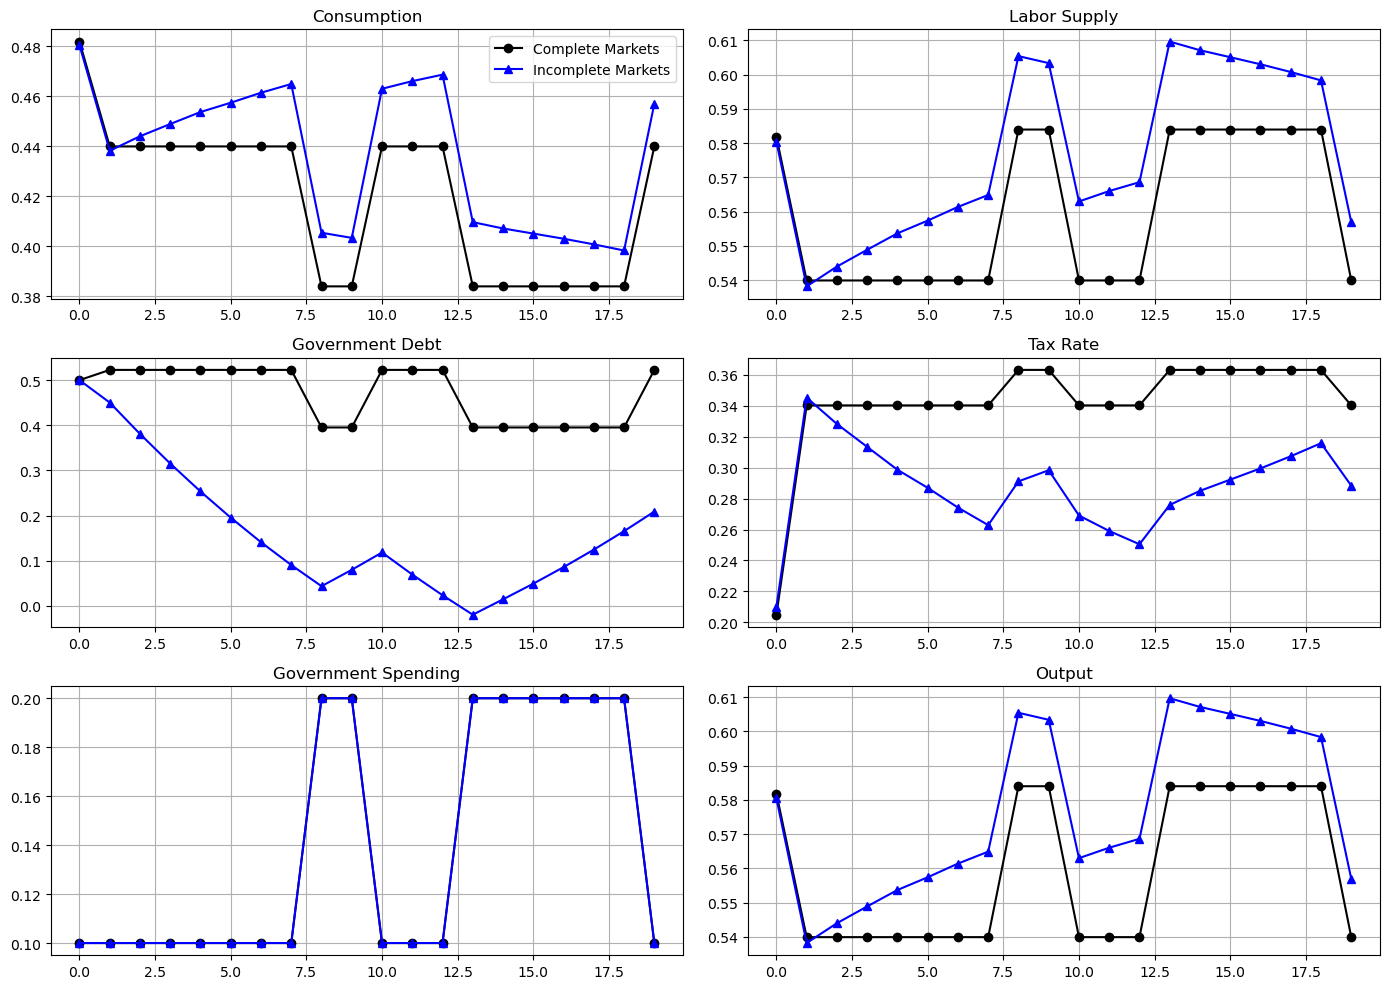

In [15]:
# WARNING: DO NOT EXPECT THE CODE TO WORK IF YOU CHANGE PARAMETERS
s_hist = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
                   0, 0, 0, 1, 1, 1, 1, 1, 1, 0])

T = len(s_hist)

sim_amss = amss_model.simulate(s_hist, b_0)
sim_ls = ls_model.simulate(0.5, 0, T, s_hist)

titles = ['Consumption', 'Labor Supply', 'Government Debt',
          'Tax Rate', 'Government Spending', 'Output']

fig, axes = plt.subplots(3, 2, figsize=(14, 10))

for ax, title, ls, amss in zip(axes.flatten(), titles, sim_ls, sim_amss):
    ax.plot(ls, '-ok', amss, '-^b')
    ax.set(title=title)
    ax.grid()

axes[0, 0].legend(('Complete Markets', 'Incomplete Markets'))
plt.tight_layout()
plt.show()

When the government experiences a prolonged period of peace, it is able to reduce
government debt and set persistently lower tax rates.

However, the government  finances a long war by borrowing and raising taxes.

This results in a drift away from  policies with state-contingent debt that
depends on the history of shocks.

This is even more evident in the following figure that plots the evolution of
the two policies over 200 periods.

This outcome reflects the presence of a force for **precautionary saving** that the incomplete markets structure imparts to the Ramsey plan.

In {doc}`this subsequent lecture <amss2>` and  {doc}`this subsequent lecture <amss3>`, some ultimate consequences of that force are explored.

In [16]:
T = 200
s_0 = 0
mc = MarkovChain(Π)

s_hist_long = mc.simulate(T, init=s_0, random_state=5)

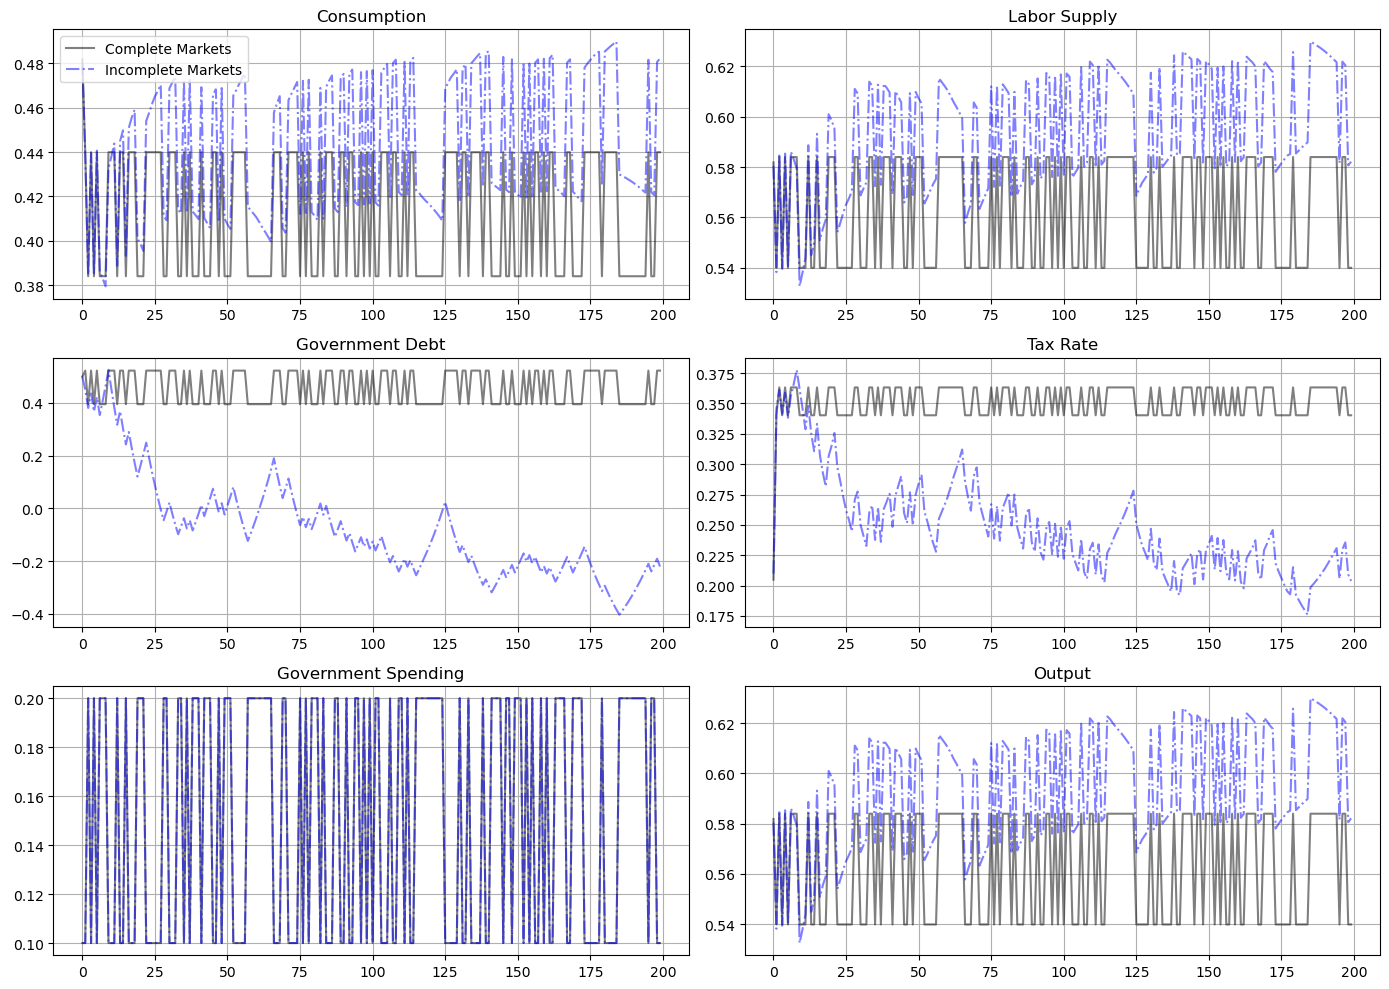

In [17]:
sim_amss = amss_model.simulate(s_hist_long, b_0)
sim_ls = ls_model.simulate(0.5, 0, T, s_hist_long)

titles = ['Consumption', 'Labor Supply', 'Government Debt',
          'Tax Rate', 'Government Spending', 'Output']


fig, axes = plt.subplots(3, 2, figsize=(14, 10))

for ax, title, ls, amss in zip(axes.flatten(), titles, sim_ls, \
        sim_amss):
    ax.plot(ls, '-k', amss, '-.b', alpha=0.5)
    ax.set(title=title)
    ax.grid()

axes[0, 0].legend(('Complete Markets','Incomplete Markets'))
plt.tight_layout()
plt.show()

[^fn_a]: In an allocation that solves the Ramsey problem and that levies distorting
taxes on labor, why would the government ever want to hand revenues back
to the private sector? It would not in an economy with state-contingent debt, since
any such allocation could be improved by lowering distortionary taxes
rather than handing out lump-sum transfers. But, without state-contingent
debt there can be circumstances when a government would like to make
lump-sum transfers to the private sector.

[^fn_b]: From the first-order conditions for the Ramsey
problem, there exists another realization $\tilde s^t$ with
the same history up until the previous period, i.e., $\tilde s^{t-1}=
s^{t-1}$, but where the multiplier on constraint {eq}`AMSS_46` takes  a positive value, so
$\gamma_t(\tilde s^t)>0$.